### MACHINE LEARNING FOR FINANCIAL MARKETS

TOPIC: IMPROVING TIME SERIES FORECASTING WITH SYNTHETIC DATA

Tools used: XGBOOST and TimeGAN (specifically introduced for Time Series)

## Proposed Methodology
The methodology is divided into two main parts:

**Part 1: Training a XGBOOST on Real Data**
- Training Phase: Train an XGBOOST using only the original (real) training dataset. Find best parameters using Cross Validation.
- Prediction and Evaluation: Apply the trained XGBOOST model to unseen test data to make predictions. Evaluate the model's performance using metrics such as Mean Squared Error (MSE) and Mean Absolute Error (MAE).

**Part 2: Augmenting the Dataset with Synthetic Data and Training a New XGBOOST Model**
- Synthetic Data Generation: Build and train a TimeGAN (Time-series Generative Adversarial Network) to generate synthetic time-series data. Combine the synthetic data with the original training dataset to create an augmented training dataset.
- Training Phase: Train a new XGBOOST on the augmented training dataset.
- Prediction and Evaluation: Apply the new XGBOOST model to the same unseen test data to make predictions. Evaluate its performance using the same metrics (MSE and MAE).

**Part 3: Comparison and Analysis**
- Compare the performance of the two XGBOOST models: The first model, trained only on real data. The second model, trained on the augmented dataset (real + synthetic data) Measure whether the inclusion of synthetic data leads to an improvement in performance.


**Expected Outcomes**
The comparison will reveal whether the augmented dataset (real + synthetic data) leads to better performance compared to using only real data.
If the synthetic data is of high quality and captures the underlying patterns of the real data, the second LSTM model is expected to achieve lower MSE and MAE on the test set.

In [347]:
#Import all the necessary libraries for LSTM and GANs

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam #adam is the optimizer we are going to use
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Dropout

In [348]:
#!pip install xgboost

# STEP 0: Explore the dataset

In [349]:
#load the dataset (data from 02/20/2015 to 02/19/2025)
path = '/Users/francescavasta/Desktop/ADSEM/II YEAR I SEM/ML for financial markets/MSFT historical data.csv'
df = pd.read_csv(path)

df = df[['Date', 'Close/Last']]
df.info()

#we see that we have a problem with the date format because it is a string
#also the stock value is a string

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2515 entries, 0 to 2514
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        2515 non-null   object
 1   Close/Last  2515 non-null   object
dtypes: object(2)
memory usage: 39.4+ KB


In [350]:
#handling of ['Date'] values
import datetime

def str_to_datetime(s):
    split = s.split('/')
    month, day, year = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month = month, day=day)

#testing the function
#datetime_object = str_to_datetime('02/20/2015')
#datetime_object

df['Date'] = df['Date'].apply(str_to_datetime)
df

,Date,Close/Last
0,2025-02-19,$414.77
1,2025-02-18,$409.64
2,2025-02-14,$408.43
3,2025-02-13,$410.54
4,2025-02-12,$409.04
...,...,...
2510,2015-02-26,$44.055
2511,2015-02-25,$43.99
2512,2015-02-24,$44.09
2513,2015-02-23,$44.15


In [351]:
#handling of Close/Last values
df["Close/Last"] = df["Close/Last"].str.replace(r"\$", "", regex=True) # to remove $
df["Close/Last"] = pd.to_numeric(df["Close/Last"], errors="coerce")
df['Close/Last'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2515 entries, 0 to 2514
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        2515 non-null   datetime64[ns]
 1   Close/Last  2515 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 39.4 KB


In [352]:
#we prefer to have our data ordered chronologically from past to future 
df = df.sort_values(by="Date", ascending=True)
df = df.reset_index(drop=True)
df

,Date,Close/Last
0,2015-02-20,43.855
1,2015-02-23,44.150
2,2015-02-24,44.090
3,2015-02-25,43.990
4,2015-02-26,44.055
...,...,...
2510,2025-02-12,409.040
2511,2025-02-13,410.540
2512,2025-02-14,408.430
2513,2025-02-18,409.640


In [353]:
#now we want to remove the index and make the date itslef as the index
df.index = df.pop('Date')
df

,Close/Last
Date,
2015-02-20,43.855
2015-02-23,44.150
2015-02-24,44.090
2015-02-25,43.990
2015-02-26,44.055
...,...
2025-02-12,409.040
2025-02-13,410.540
2025-02-14,408.430


In [354]:
#The function scrolls the DataFrame and creates time sequences (windows) of past data 
# to predict the future data (target).

def df_to_windowed_df (dataframe, first_date_str,last_date_str, n = 5): 
    first_date = str_to_datetime(first_date_str)
    last_date = str_to_datetime(last_date_str)

    target_date = first_date

    dates = []
    X,Y = [], []

    last_time = False
    while True:
        df_subset = dataframe.loc[:target_date].tail(n+1)

        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date')
            return
    
        values = df_subset['Close/Last'].to_numpy()
        x, y = values [:-1], values [-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        # Find the next date
        next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
        next_datetime_str=str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year_month_day = next_date_str.split('-')
        year, month, day = year_month_day
        next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
        
        # Find the next date
        #next_date = target_date + datetime.timedelta(days=1)  # Assuming the next day is the next target date
        
        #target_date = next_date

        if last_time: 
            break 

        target_date = next_date
        
        if target_date == last_date:
            last_time = True
        

    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates

    X = np.array (X)
    for i in range (0,n):
        X[:, i]
        ret_df[f'Target - {n-i}'] = X[:, i]
    
    ret_df['Target'] = Y 

    return ret_df    

In [355]:
#apply the function. The start date can't be 20/02/2015 because it must have 5 other dates prior
windowed_df = df_to_windowed_df(df,'02/27/2015', '02/19/2025' ,n = 5)

windowed_df

,Target Date,Target - 5,Target - 4,Target - 3,Target - 2,Target - 1,Target
0,2015-02-27,43.855,44.150,44.090,43.990,44.055,43.850
1,2015-03-02,44.150,44.090,43.990,44.055,43.850,43.880
2,2015-03-03,44.090,43.990,44.055,43.850,43.880,43.280
3,2015-03-04,43.990,44.055,43.850,43.880,43.280,43.055
4,2015-03-05,44.055,43.850,43.880,43.280,43.055,43.110
...,...,...,...,...,...,...,...
2505,2025-02-12,413.290,415.820,409.750,412.220,411.440,409.040
2506,2025-02-13,415.820,409.750,412.220,411.440,409.040,410.540
2507,2025-02-14,409.750,412.220,411.440,409.040,410.540,408.430
2508,2025-02-18,412.220,411.440,409.040,410.540,408.430,409.640


In [356]:
#this function helps us to distinguish the target variable from the predictors
def windowed_df_to_date_X_y (windowed_dataframe):
    df_as_np = windowed_dataframe.to_numpy()

    dates = df_as_np[:, 0]

    middle_matrix  = df_as_np [:, 1:-1] #to take only the "Target-n" columns
    #middle matrix is not the final input matrix

    X = middle_matrix.reshape((len(dates),middle_matrix.shape[1], 1)) #"1" because it is univariate forecasting
    #if we used also the volume variable, then we would need to change the number

    Y = df_as_np[:, -1]

    return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X_orig, y_orig = windowed_df_to_date_X_y(windowed_df)

dates.shape, X_orig.shape, y_orig.shape

((2510,), (2510, 5, 1), (2510,))

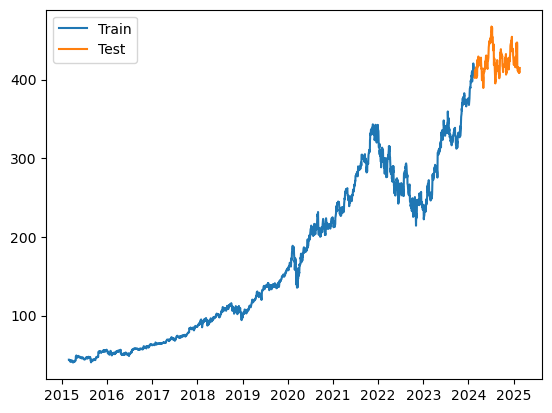

In [357]:
# Now we split the data and we also visualize the different sets on the graph
#with time series we can't do random splittings because the cronological order is important, so we use the quantiles

q_90 = int(len(dates)*.9)

#splitting also the non-standardized dataset for future plots
dates_train, X_train_orig, y_train_orig = dates[:q_90], X_orig[:q_90], y_orig[:q_90]
dates_test, X_test_orig, y_test_orig = dates[q_90:], X_orig[q_90:], y_orig[q_90:] #from q_90 onwards

plt.plot(dates_train, y_train_orig)
plt.plot(dates_test, y_test_orig)

plt.legend(['Train','Test'])

# PART 1: XGBOOST trained on original data

In [358]:
# Reshape X data from (samples, time_steps, 1) to (samples, time_steps)
X_train_XGB= X_train_orig.reshape(X_train_orig.shape[0], X_train_orig.shape[1])
X_test_XGB = X_test_orig.reshape(X_test_orig.shape[0], X_test_orig.shape[1])

y_train_XGB = y_train_orig.ravel() 
y_test_XGB = y_test_orig.ravel() 


from xgboost import XGBRegressor

model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(X_train_XGB, y_train_XGB)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [359]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Define parameters to test
param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [5, 7, 10],
    'learning_rate': [0.01, 0.03, 0.05],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# Create the base model
model = XGBRegressor(objective='reg:squarederror')

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=1)

# Run the grid search
grid_search.fit(X_train_XGB, y_train_XGB)

# Print the best parameters found
print("Best parameters:", grid_search.best_params_)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 10, 'n_estimators': 1000, 'subsample': 0.7}


In [362]:
# Save the best model
best_model = grid_search.best_estimator_

#Let's try to predict the first item for the y_test set using the first item of X_train
X_test_XGB[0], y_test_XGB[0] #1st item in the test set
val = np.array(X_test_XGB[0].reshape(1,-1))
pred = best_model.predict(val)

val, pred

(array([[415.26, 406.32, 409.49, 406.56, 404.06]], dtype=float32),
 array([408.4636], dtype=float32))

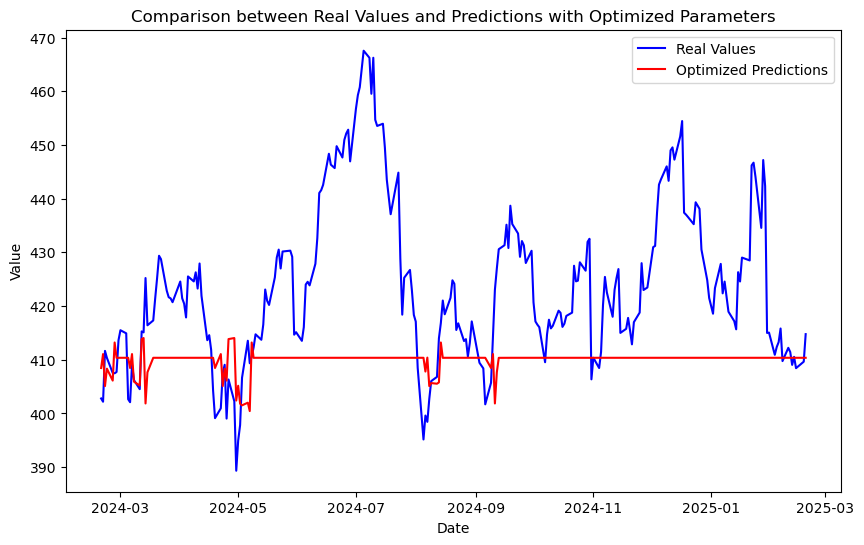

In [363]:
# Use the best model to make predictions
y_pred_best = best_model.predict(X_test_XGB)

# Create the plot with the new predictions
plt.figure(figsize=(10, 6))
plt.plot(dates_test, y_test_XGB, label='Real Values', color='blue')
plt.plot(dates_test, y_pred_best, label='Optimized Predictions', color='red', linestyle='solid')

# Add labels and legend
plt.title("Comparison between Real Values and Predictions with Optimized Parameters")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()

plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test_XGB, y_pred_best)
print(f"Mean Absolute Error (MAE): {mae}")


Mean Absolute Error (MAE): 15.190549850463867


In [182]:
X_train_XGB

array([[ 43.855,  44.15 ,  44.09 ,  43.99 ,  44.055],
       [ 44.15 ,  44.09 ,  43.99 ,  44.055,  43.85 ],
       [ 44.09 ,  43.99 ,  44.055,  43.85 ,  43.88 ],
       ...,
       [414.05 , 414.11 , 420.55 , 415.26 , 406.32 ],
       [414.11 , 420.55 , 415.26 , 406.32 , 409.49 ],
       [420.55 , 415.26 , 406.32 , 409.49 , 406.56 ]], dtype=float32)

In [183]:
y_train_XGB

array([ 43.85,  43.88,  43.28, ..., 409.49, 406.56, 404.06], dtype=float32)

# PART 2: Use TimeGAN to generate synthetic data. Then fit the LSTM on augmented training data.

In [226]:
#first let's scale the data because the TimeGAN will use "tahn"

X_scaler = MinMaxScaler(feature_range=(-1, 1))
# Riformatta i dati per la scalatura
X_train_reshaped = X_train_orig.reshape(-1, X_train_orig.shape[-1])
# Applica la scalatura
X_train_scaled = X_scaler.fit_transform(X_train_reshaped)
# Riporta i dati alla forma originale
X_train_scaled = X_train_scaled.reshape(X_train_orig.shape)

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling1D

class TimeGAN:
    def __init__(self, seq_len, feature_dim, hidden_dim=128, batch_size=128):
        self.seq_len = seq_len
        self.feature_dim = feature_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.build_model()

    def build_model(self):
        # Generator: Fully Connected Network
        self.generator = Sequential([
            Dense(self.hidden_dim, input_dim=self.seq_len * self.feature_dim, activation='relu'),
            Dropout(0.2),
            Dense(self.hidden_dim * 2, activation='relu'),
            Dropout(0.2),
            Dense(self.seq_len * self.feature_dim, activation='tanh'),
            Reshape((self.seq_len, self.feature_dim))
        ])

        # Discriminator: Fully Connected Network
        self.discriminator = Sequential([
            Dense(self.hidden_dim * 2, input_shape=(self.seq_len, self.feature_dim), activation='relu'),
            Dropout(0.3),
            Dense(self.hidden_dim, activation='relu'),
            GlobalAveragePooling1D(),  # Aggiunto pooling per ridurre a un singolo valore
            Dense(1, activation='sigmoid')  # Output scalare
        ])

        # Compile Discriminator
        self.discriminator.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

        # GAN Model (Generator + Discriminator)
        self.discriminator.trainable = False
        gan_input = tf.keras.Input(shape=(self.seq_len * self.feature_dim,))
        generated_data = self.generator(gan_input)
        gan_output = self.discriminator(generated_data)
        self.gan = Model(gan_input, gan_output)

        # Compile GAN Model
        self.gan.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy')

    
    def train(self, data, epochs=1000):
        d_losses, g_losses = [], []

        for epoch in range(epochs):
            # Train the Discriminator
            idx = np.random.randint(0, data.shape[0], self.batch_size)
            real_samples = data[idx]
            noise = np.random.normal(0, 2, (self.batch_size, self.seq_len * self.feature_dim))#add some variance
            fake_samples = self.generator.predict(noise, verbose=0)

            real_labels = np.ones((self.batch_size, 1))
            fake_labels = np.zeros((self.batch_size, 1))

            # Train the Discriminator on real samples
            d_loss_real = self.discriminator.train_on_batch(real_samples, real_labels)
            # Train the Discriminator on fake samples
            d_loss_fake = self.discriminator.train_on_batch(fake_samples, fake_labels)

            # Average Discriminator loss
            d_loss = 0.5 * np.add(d_loss_real[0], d_loss_fake[0])  # Usa solo la loss (primo elemento)

            # Train the Generator
            noise = np.random.normal(0, 2, (self.batch_size, self.seq_len * self.feature_dim))
            g_loss = self.gan.train_on_batch(noise, np.ones((self.batch_size, 1)))

            # Add losses to the list
            d_losses.append(d_loss)
            g_losses.append(g_loss)

            # Print the loss every 100 epochs
            if epoch % 100 == 0:
                print(f"Epoch {epoch}: D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}")

        # Plot of the loss
        plt.figure(figsize=(10, 6))
        plt.plot(d_losses, label='Discriminator Loss', alpha=0.7)
        plt.plot(g_losses, label='Generator Loss', alpha=0.7)
        plt.title('GAN Training Progress')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    def generate_synthetic_data(self, num_samples):
        noise = np.random.normal(0, 1, (num_samples, self.seq_len * self.feature_dim))
        generated_data = self.generator.predict(noise)
        return generated_data

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 0: D Loss: 0.6771, G Loss: 0.6827
Epoch 100: D Loss: 0.6987, G Loss: 0.6592
Epoch 200: D Loss: 0.6999, G Loss: 0.6571
Epoch 300: D Loss: 0.7003, G Loss: 0.6564
Epoch 400: D Loss: 0.7005, G Loss: 0.6560
Epoch 500: D Loss: 0.7007, G Loss: 0.6558
Epoch 600: D Loss: 0.7008, G Loss: 0.6556
Epoch 700: D Loss: 0.7008, G Loss: 0.6555
Epoch 800: D Loss: 0.7009, G Loss: 0.6555
Epoch 900: D Loss: 0.7009, G Loss: 0.6554


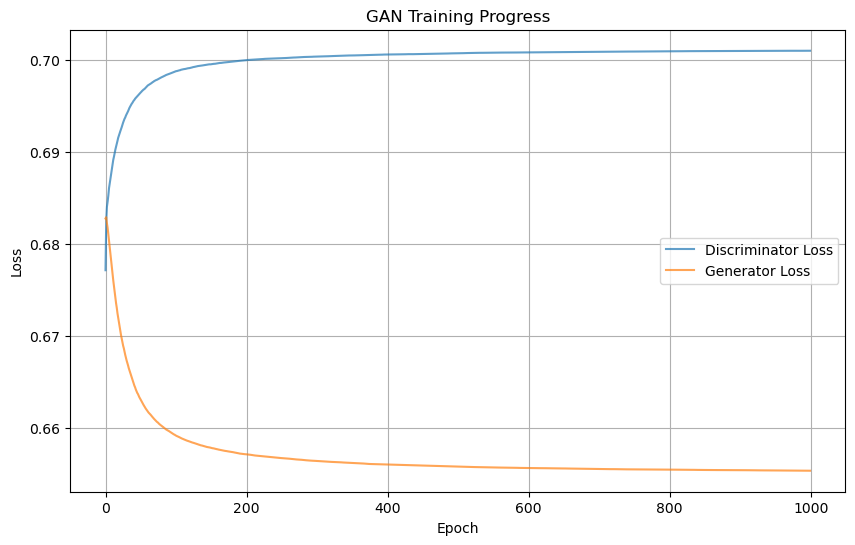

In [321]:
# Training the TimeGAN
seq_len = X_train_orig.shape[1] #output: 5
feature_dim = 1 
timegan = TimeGAN(5, 1)
timegan.train(X_train_scaled, epochs=1000)

## generate synthetic data with TimeGAN (20% of X_train) and augment the training dataset

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


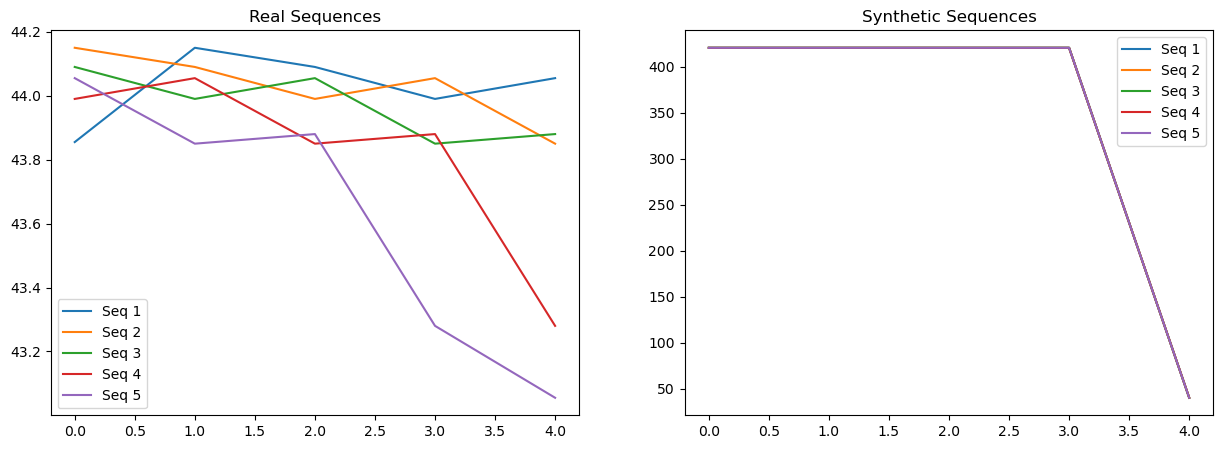

In [ ]:
# 1. Generate su X_train_norm
num_synthetic = int(X_train_orig.shape[0] * 0.5)  # 30% di dati sintetici
synthetic_sequences = timegan.generate_synthetic_data(num_synthetic)
# Reshape data to apply inverse scaler
synthetic_reshaped = synthetic_sequences.reshape(-1, synthetic_sequences.shape[-1])
# apply inverse scaler
synthetic_sequences_rescaled = X_scaler.inverse_transform(synthetic_reshaped)
# reshape data to original shape
synthetic_sequences_rescaled = synthetic_sequences_rescaled.reshape(synthetic_sequences.shape)

# 2. Use the best XGBOOST (found before) to generate synthetic targets
synthetic_sequences_flat = synthetic_sequences.reshape((synthetic_sequences.shape[0], -1))
synthetic_targets = best_model.predict(synthetic_sequences_flat)
#since our goal is forecasting, we also need to generate synthetic targets using the same XGBOOST model defined before

# 2. Plot and compare synthetic and original sequences
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

for i in range(5):
    plt.plot(X_train_orig[i, :, 0], label=f'Seq {i+1}')
plt.title('Real Sequences')
plt.legend()

plt.subplot(1, 2, 2)
for i in range(5):
    plt.plot(synthetic_sequences_rescaled[i, :, 0], label=f'Seq {i+1}')
plt.title('Synthetic Sequences')
plt.legend()
plt.show()



In [330]:
# 3. Combine syntehtic and real
X_train_augmented = np.concatenate([X_train_orig, synthetic_sequences_rescaled], axis=0)
X_train_XGB_augmented = X_train_augmented.reshape(X_train_augmented.shape[0], X_train_augmented.shape[1])
y_train_XGB_augmented = np.concatenate([y_train_orig, synthetic_targets], axis=0)

# 4. Shuffle the data
shuffle_idx = np.random.permutation(len(X_train_XGB_augmented))
X_train_XGB_augmented = X_train_XGB_augmented[shuffle_idx]
y_train_XGB_augmented = y_train_XGB_augmented[shuffle_idx]

X_train_XGB_augmented, y_train_XGB_augmented


(array([[112.09    , 108.52    , 109.19    , 104.82    , 107.59    ],
        [ 56.26    ,  57.19    ,  57.25    ,  56.93    ,  56.81    ],
        [420.53778 , 420.53845 , 420.5401  , 420.53607 ,  40.304726],
        ...,
        [250.66    , 231.32    , 226.75    , 235.87    , 232.13    ],
        [420.5463  , 420.54495 , 420.54767 , 420.54694 ,  40.294346],
        [ 57.95    ,  58.17    ,  58.03    ,  58.1     ,  57.89    ]],
       dtype=float32),
 array([108.59    ,  57.76    ,  40.944084, ..., 228.17    ,  40.944084,
         57.46    ], dtype=float32))

In [ ]:
print("Real data statistics (X_train_orig):")
print("Average:", np.mean(X_train_orig, axis=0))
print("Standard Deviation:", np.std(X_train_orig, axis=0))

print("\Synthetic data statistics (synthetic_sequences_rescaled):")
print("Average:", np.mean(synthetic_sequences_rescaled, axis=0))
print("Standard Deviation:", np.std(synthetic_sequences_rescaled, axis=0))

Statistiche dei dati reali (X_train_orig):
Media: [[166.41354]
 [166.57796]
 [166.73827]
 [166.90004]
 [167.06053]]
Deviazione standard: [[102.579254]
 [102.68028 ]
 [102.771706]
 [102.86605 ]
 [102.95696 ]]

Statistiche dei dati sintetici (synthetic_sequences_rescaled):
Media: [[420.36032 ]
 [420.36154 ]
 [420.3546  ]
 [420.35693 ]
 [ 40.473034]]
Deviazione standard: [[0.59202546]
 [0.5844546 ]
 [0.5888266 ]
 [0.5809649 ]
 [0.5619904 ]]


In [316]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# 5. Train XGBOOST again with the augmented training dataset and find best parameters

# Define parameters to test
param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [5, 7, 10],
    'learning_rate': [0.01, 0.03, 0.05],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# Create the base model
augmented_model = XGBRegressor(objective='reg:squarederror')

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=augmented_model, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=1)

# Run the grid search
grid_search.fit(X_train_XGB_augmented, y_train_XGB_augmented)

# Print the best parameters found
print("Best parameters:", grid_search.best_params_)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits


/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 1000, 'subsample': 0.7}


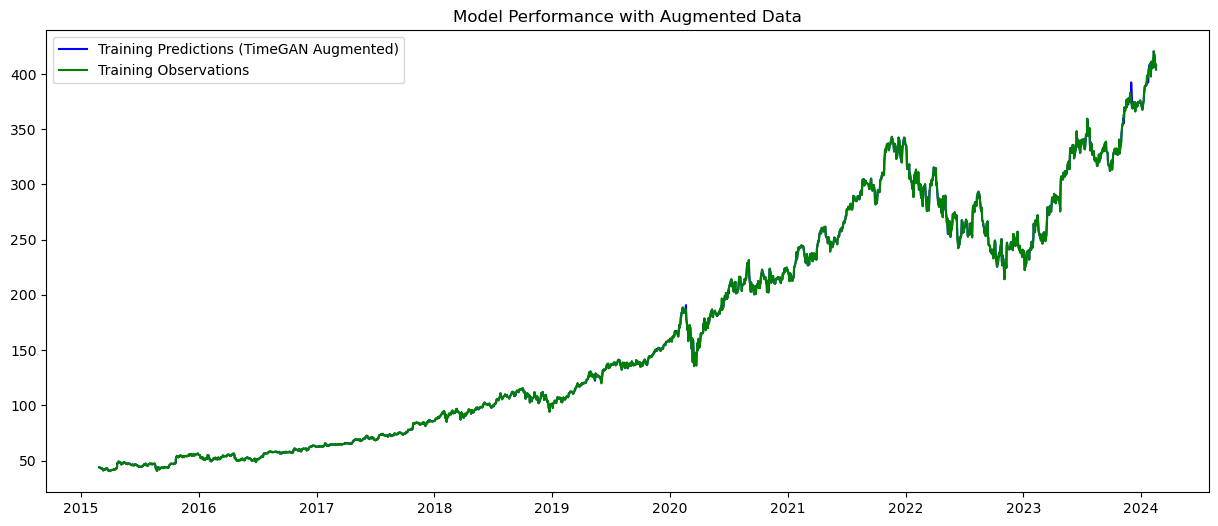

MSE sul training set: 0.5380
R2 sul training set: 0.9999


In [ ]:
# Use the best model to make predictions
best_model_aug = grid_search.best_estimator_
best_model_aug.fit(X_train_XGB_augmented, y_train_XGB_augmented)

# Check the performance of the XGBOOST model with AUGMENTED DATA on train set
y_train_pred_aug = best_model_aug.predict(X_train_XGB)


# Plot results
plt.figure(figsize=(15, 6))
plt.plot(dates_train, y_train_pred_aug, 'b', label='Training Predictions (TimeGAN Augmented)')
plt.plot(dates_train, y_train_XGB, 'g', label='Training Observations')
plt.legend()
plt.title('Model Performance with Augmented Data')
plt.show()

mse_train = mean_squared_error(y_train_XGB, y_train_pred_aug)
r2_train = r2_score(y_train_XGB, y_train_pred_aug)

print(f"MSE sul training set: {mse_train:.4f}")
print(f"R2 sul training set: {r2_train:.4f}")

# COMPARISON and PERFORMANCE ASSESSMENT

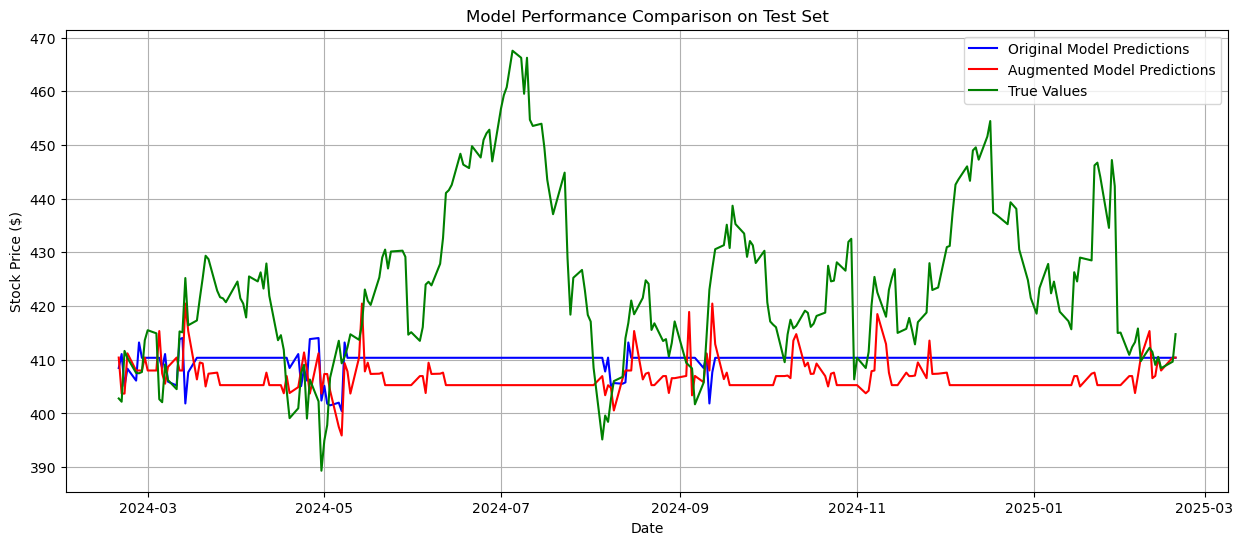

In [ ]:
# 1. make predictions on the same test set using the two different XGBOOST
test_predictions_aug = best_model_aug.predict(X_test_XGB) # XGBOOST model fit on augmented training dataset
test_predictions = best_model.predict(X_test_XGB)# XGBOOST model fit on original training dataset

# 2. Comparison
plt.figure(figsize=(15, 6))
plt.plot(dates_test, test_predictions, 'b', label='Original Model Predictions')
plt.plot(dates_test, test_predictions_aug, 'r', label='Augmented Model Predictions')
plt.plot(dates_test, y_test_XGB, 'g', label='True Values')
plt.title('Model Performance Comparison on Test Set')
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')
plt.legend()
plt.grid(True)
plt.show()

In [334]:
#Original model performance
mae_original = mean_absolute_error(y_test_orig, test_predictions)
rmse_original = np.sqrt(mean_squared_error(y_test_orig, test_predictions))

#Performance of model with augmented data
mae_augmented = mean_absolute_error(y_test_orig, test_predictions_aug)
rmse_augmented = np.sqrt(mean_squared_error(y_test_orig, test_predictions_aug))

print("\nTest Set Performance Metrics:")
print("\nOriginal Model:")
print(f"MAE: ${mae_original:.2f}")
print(f"RMSE: ${rmse_original:.2f}")

print("\nAugmented Model:")
print(f"MAE: ${mae_augmented:.2f}")
print(f"RMSE: ${rmse_augmented:.2f}")

#Improvement thanks to the synthetic data
mae_improvement = ((mae_original - mae_augmented) / mae_original) * 100
rmse_improvement = ((rmse_original - rmse_augmented) / rmse_original) * 100

print(f"\nImprovement with Data Augmentation:")
print(f"MAE Improvement: {mae_improvement:.2f}%")
print(f"RMSE Improvement: {rmse_improvement:.2f}%")


Test Set Performance Metrics:

Original Model:
MAE: $15.19
RMSE: $19.95

Augmented Model:
MAE: $18.12
RMSE: $23.10

Improvement with Data Augmentation:
MAE Improvement: -19.30%
RMSE Improvement: -15.76%
